## Importing Necessary Libraries

In [ ]:
# libraries for basic usage
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# libraries for model creation and classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
# libraries for project usage
import os
import librosa
import librosa.display
import glob 
import skimage
from scipy.io import wavfile as wav
from tqdm.notebook import tqdm, trange

## Data Analysis

### Creation of Dataframe

In [ ]:
df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Analysing Samples using Audio Signals Plots (Scipy + Pyplot)

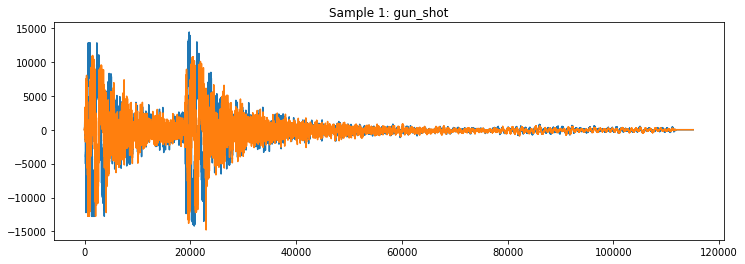

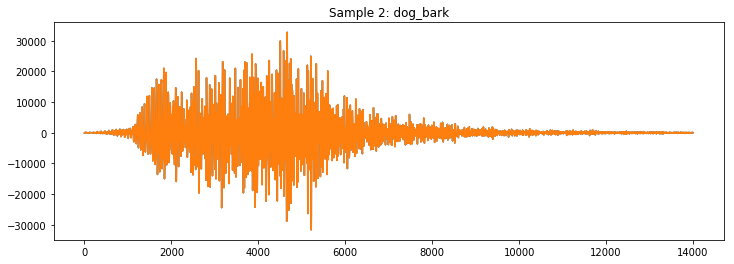

In [ ]:
rate, wav_sample = wav.read('../input/urbansound8k/fold1/102305-6-0-0.wav')
plt.figure(figsize=(12,4))
plt.title('Sample 1: gun_shot')
plt.plot(wav_sample)

rate, wav_sample = wav.read('../input/urbansound8k/fold5/100032-3-0-0.wav')
plt.figure(figsize=(12,4))
plt.title('Sample 2: dog_bark')
plt.plot(wav_sample)

### Analysing Random Samples using Spectrogram Plots (Librosa)

In [ ]:
dat1, sampling_rate1 = librosa.load('../input/urbansound8k/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('../input/urbansound8k/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear Frequency Power (Mel) spectrogram')

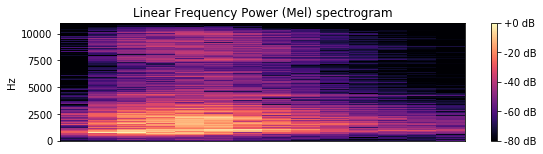

In [ ]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear Frequency Power (Mel) spectrogram')

Text(0.5, 1.0, 'Linear Frequency Power (Mel) spectrogram')

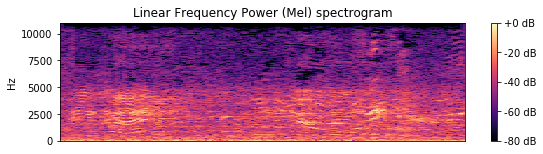

In [ ]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear Frequency Power (Mel) spectrogram')

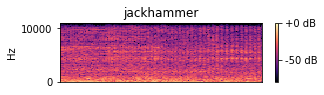

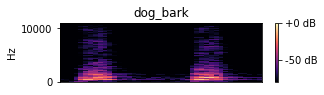

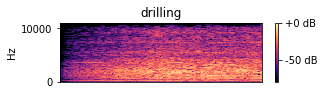

In [ ]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = '../input/urbansound8k/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

## Feature Extraction

### Extraction of Spectrogram Data as NumPy Array

In [ ]:
dat1, sampling_rate1 = librosa.load('../input/urbansound8k/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [ ]:
feature = []
label = []

def parser(row):
    for i in tqdm(range(8732)):
        file_name = '../input/urbansound8k/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [ ]:
temp = parser(df)

In [ ]:
temp = np.array(temp)
data = temp.transpose()

In [ ]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [ ]:
for i in range(8732):
    X[i] = (X_[i])

### Categorical Encoding

In [ ]:
Y = to_categorical(Y)

In [ ]:
print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


### Train-Test Dataset Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [ ]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [ ]:
input_dim = (16, 8, 1)

## Creating and Testing Keras Model (CNN-Based Architecture)

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Train on 6549 samples, validate on 2183 samples
Epoch 1/90
6549/6549 [==============================] - 4s 558us/sample - loss: 1.5264 - accuracy: 0.4753 - val_loss: 1.2489 - val_accuracy: 0.5721
Epoch 2/90
6549/6549 [==============================] - 1s 82us/sample - loss: 1.1319 - accuracy: 0.6166 - val_loss: 1.1063 - val_accuracy: 0.6464
Epoch 3/90
6549/6549 [==============================] - 1s 79us/sample - loss: 0.9388 - accuracy: 0.6854 - val_loss: 1.0093 - val_accuracy: 0.6761
Epoch 4/90
6549/6549 [==============================] - 1s 80us/sample - loss: 0.8271 - accuracy: 0.7203 - val_loss: 0.9916 - val_accuracy: 0.6748
Epoch 5/90
6549/6549 [==============================] - 1s 78us/sample - loss: 0.7515 - accuracy: 0.7494 - val_loss: 0.9247 - val_accuracy: 0.7128
Epoch 6/90
6549/6549 [==============================] - 1s 83us/sample - loss: 0.6697 - accuracy: 0.7732 - val_loss: 0.8780 - val_accuracy: 0.7329
Epoch 7/90
6549/6549 [==============================] - 1s 83us/sampl

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

## Performing Predictions

In [ ]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

2183/2183 [==============================] - 0s 71us/sample - loss: 0.8782 - accuracy: 0.8552
[0.8782114300273475, 0.85524505]


In [ ]:
preds = np.argmax(predictions, axis = 1)
Y_test_cm = np.argmax(Y_test, axis = 1)

In [ ]:
result = pd.DataFrame(preds)
result.to_csv("UrbanSound8kResults.csv")

## Generating and Plotting Confusion Matrix

[Text(0, 0.5, 'air_conditioner'),
 Text(0, 1.5, 'car_horn'),
 Text(0, 2.5, 'children_playing'),
 Text(0, 3.5, 'dog_bark'),
 Text(0, 4.5, 'drilling'),
 Text(0, 5.5, 'engine_idling'),
 Text(0, 6.5, 'gun_shot'),
 Text(0, 7.5, 'jackhammer'),
 Text(0, 8.5, 'siren'),
 Text(0, 9.5, 'street_music')]

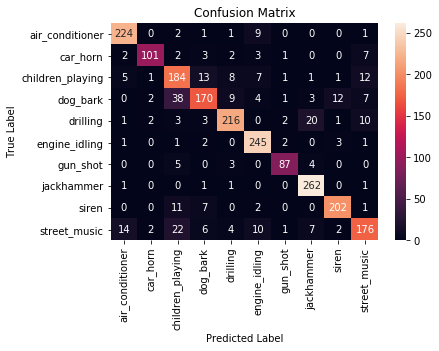

In [ ]:
cm = confusion_matrix(Y_test_cm, preds)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music'], rotation=90); ax.yaxis.set_ticklabels(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music'], rotation=0)

In [ ]:
accuracy_score(Y_test_cm, preds)

0.8552450755840586